# 1. Install and Import Dependencies

In [1]:
!pip install tensorflow tensorflow-io[tensorflow] matplotlib --quiet

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

# 2. Data Loading 

* The decode_wav function outputs the waveform with shape [samples, channels], where channels=1 (due to desired_channels=1).
* After tf.squeeze, the shape becomes [samples], simplifying the tensor to a single dimension.
```tf.cast(sample_rate, dtype=tf.int64)```
* Converts the sample_rate from its default data type (tf.int32) to tf.int64.
* Ensures compatibility with functions or operations requiring int64.

```tfio.audio.resample(wav, rate_in=sample_reate, rate_out=16000)```
* Resamples the audio waveform to a fixed sampling rate (16 kHz in this case), which is commonly used in speech processing models.

In [3]:
def load_audio(filename):
    file_contents = tf.io.read_file(filename)
    #Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Remove Trailing axis
    wav = tf.squeeze(wav, axis= -1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# 3. Plot Wave

* In this plot, the blue waveform represents the sound of a Capuchinbird, while the orange waveform represents sounds that are not from a Capuchinbird

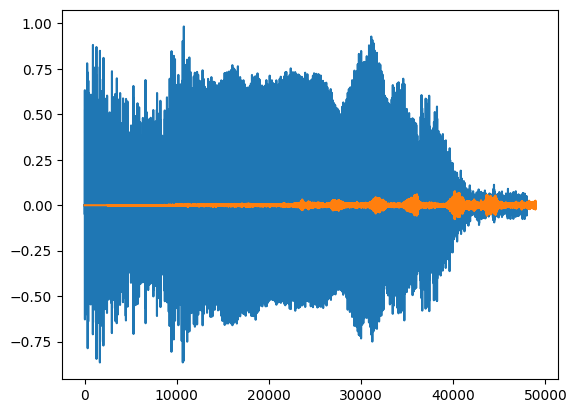

In [4]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

wave = load_audio(CAPUCHIN_FILE)
nwave = load_audio(NOT_CAPUCHIN_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()

# 4. Create Tensorflow Dataset

In [5]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

# Add Labels (Binary Classification)
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [6]:
# pos.as_numpy_iterator().next()
# tf.ones(len(pos))
# tf.zeros(len(neg))
# positives.as_numpy_iterator().next()
# negatives.as_numpy_iterator().next()
# data.shuffle(1000).as_numpy_iterator().next()

# 5. Determine Average Length of a Capuchin Call

In [7]:
# Calculate Wave Cycle Length
lengths = []
for file in os.listdir(POS):
    file_path = os.path.join(POS, file)
    tensor_wave = load_audio(file_path)
    lengths.append(len(tensor_wave))

```Time: 54156 (Mean)/16000: 3.38475 seconds```

In [8]:
# Calculate Mean, Min and Max
print(tf.math.reduce_mean(lengths))
print(tf.math.reduce_min(lengths))
print(tf.math.reduce_max(lengths))

tf.Tensor(54156, shape=(), dtype=int32)
tf.Tensor(32000, shape=(), dtype=int32)
tf.Tensor(80000, shape=(), dtype=int32)


# 6. Build Preprocessing Function to Convert to Spectrogram

* The audio is truncated to the first 48,000 samples to standardize the input size.
* Reason: Neural networks require fixed-size inputs, so truncating ensures all inputs are consistent.
* At a 16 kHz sample rate, 48,000 samples correspond to 3 seconds of audio (48000 ÷ 16000 = 3 seconds).

In [9]:
def preprocess(file_path, label): 
    wav = load_audio(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [10]:
# Create a Tensorflow Data Pipeline

data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

train = data.take(36)
test = data.skip(36).take(15)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# 7. Build Deep Learning Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import tensorflow as tf

model = Sequential()
model.add(Conv2D(12, (3, 3), activation='relu', input_shape=(1491, 257, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(12, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(12, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

hist = model.fit(train, epochs=4, validation_data=test, batch_size=16)

Epoch 1/4
36/36 [==============================] - 62s 1s/step - loss: 0.2201 - accuracy: 0.9271 - recall: 0.8288 - precision: 0.8768 - val_loss: 0.0661 - val_accuracy: 0.9744 - val_recall: 0.9714 - val_precision: 0.9444
Epoch 2/4
36/36 [==============================] - 53s 1s/step - loss: 0.0502 - accuracy: 0.9844 - recall: 0.9600 - precision: 0.9796 - val_loss: 0.0238 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 53s 1s/step - loss: 0.0270 - accuracy: 0.9913 - recall: 0.9822 - precision: 0.9881 - val_loss: 0.0299 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 53s 1s/step - loss: 0.0279 - accuracy: 0.9878 - recall: 0.9592 - precision: 0.9930 - val_loss: 0.0548 - val_accuracy: 0.9829 - val_recall: 1.0000 - val_precision: 0.9437


# 8. View Loss Plot

In [12]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'])


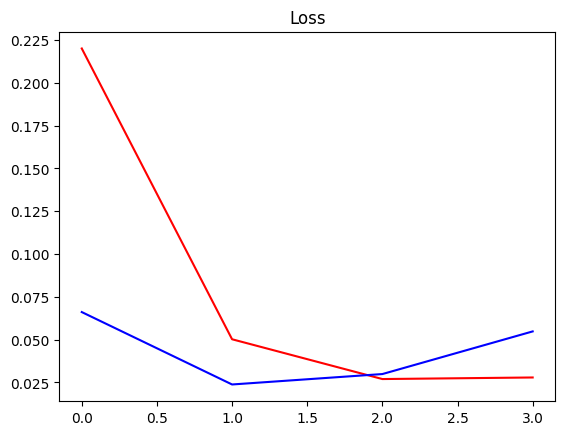

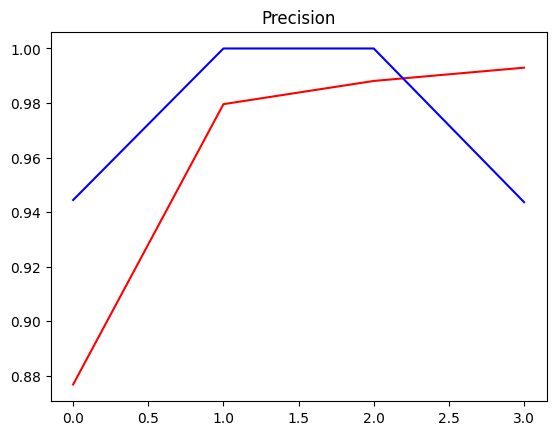

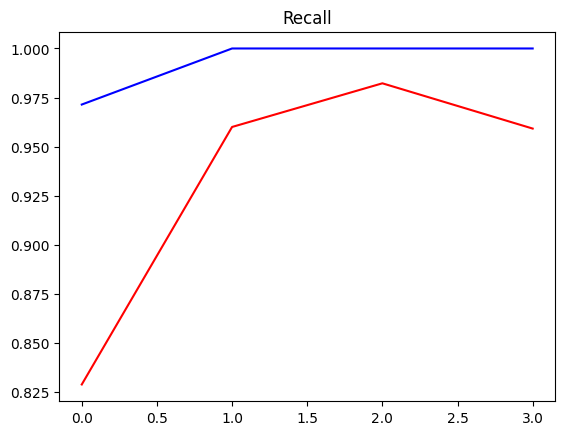

In [14]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 9. Make a Prediction on a Single Clip

In [16]:
X_test, y_test = test.as_numpy_iterator().next()

yhat = model.predict(X_test)

# Convert Logits to Classes
yhat_classes = [1 if prediction > 0.5 else 0 for prediction in yhat]

print("Predictions (yhat):", yhat_classes)
print("Actual Labels (y_test):", y_test.tolist())

1/1 [==============================] - 1s 559ms/step
Predictions (yhat): [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Actual Labels (y_test): [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]


# 10. Save The Model

In [17]:
# Save model in Keras format (SavedModel)
model.save('model.keras')

# Save model in Pickle format (SavedModel)
import pickle

# Serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to Pickle
with open("model_weights.pkl", "wb") as weights_file:
    pickle.dump(model.get_weights(), weights_file)